In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns

In [ ]:
data = pd.read_csv('Mental-Health-Twitter.csv')
data.head()

,Unnamed: 0,post_id,post_created,post_text,user_id,followers,friends,favourites,statuses,retweets,label
0,0,637894677824413696,Sun Aug 30 07:48:37 +0000 2015,It's just over 2 years since I was diagnosed w...,1013187241,84,211,251,837,0,1
1,1,637890384576778240,Sun Aug 30 07:31:33 +0000 2015,"It's Sunday, I need a break, so I'm planning t...",1013187241,84,211,251,837,1,1
2,2,637749345908051968,Sat Aug 29 22:11:07 +0000 2015,Awake but tired. I need to sleep but my brain ...,1013187241,84,211,251,837,0,1
3,3,637696421077123073,Sat Aug 29 18:40:49 +0000 2015,RT @SewHQ: #Retro bears make perfect gifts and...,1013187241,84,211,251,837,2,1
4,4,637696327485366272,Sat Aug 29 18:40:26 +0000 2015,It’s hard to say whether packing lists are mak...,1013187241,84,211,251,837,1,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    20000 non-null  int64 
 1   post_id       20000 non-null  int64 
 2   post_created  20000 non-null  object
 3   post_text     20000 non-null  object
 4   user_id       20000 non-null  int64 
 5   followers     20000 non-null  int64 
 6   friends       20000 non-null  int64 
 7   favourites    20000 non-null  int64 
 8   statuses      20000 non-null  int64 
 9   retweets      20000 non-null  int64 
 10  label         20000 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 1.7+ MB


In [ ]:
data.corr()

<ipython-input-4-c44ded798807>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,Unnamed: 0,post_id,user_id,followers,friends,favourites,statuses,retweets,label
Unnamed: 0,1.000000,0.600563,0.212532,0.023582,-0.137532,0.089637,0.343269,0.010289,-0.866025
post_id,0.600563,1.000000,0.166659,-0.014575,-0.047579,0.293741,0.194367,0.031601,-0.746612
user_id,0.212532,0.166659,1.000000,0.098022,-0.073787,-0.050215,-0.050672,-0.020921,-0.220954
followers,0.023582,-0.014575,0.098022,1.000000,0.891919,-0.016242,-0.000215,0.001500,-0.011181
friends,-0.137532,-0.047579,-0.073787,0.891919,1.000000,-0.081756,-0.045420,0.009946,0.119818
favourites,0.089637,0.293741,-0.050215,-0.016242,-0.081756,1.000000,-0.053930,0.069551,-0.252289
statuses,0.343269,0.194367,-0.050672,-0.000215,-0.045420,-0.053930,1.000000,-0.005193,-0.246473
retweets,0.010289,0.031601,-0.020921,0.001500,0.009946,0.069551,-0.005193,1.000000,-0.025198
label,-0.866025,-0.746612,-0.220954,-0.011181,0.119818,-0.252289,-0.246473,-0.025198,1.000000


In [ ]:
column_drop = ['Unnamed: 0','post_id','user_id']
data.drop(columns=column_drop,inplace=True,axis=1)
data.head()

,post_created,post_text,followers,friends,favourites,statuses,retweets,label
0,Sun Aug 30 07:48:37 +0000 2015,It's just over 2 years since I was diagnosed w...,84,211,251,837,0,1
1,Sun Aug 30 07:31:33 +0000 2015,"It's Sunday, I need a break, so I'm planning t...",84,211,251,837,1,1
2,Sat Aug 29 22:11:07 +0000 2015,Awake but tired. I need to sleep but my brain ...,84,211,251,837,0,1
3,Sat Aug 29 18:40:49 +0000 2015,RT @SewHQ: #Retro bears make perfect gifts and...,84,211,251,837,2,1
4,Sat Aug 29 18:40:26 +0000 2015,It’s hard to say whether packing lists are mak...,84,211,251,837,1,1


In [ ]:
#Mengecek Data Missing
data.isnull().sum()

post_created    0
post_text       0
followers       0
friends         0
favourites      0
statuses        0
retweets        0
label           0
dtype: int64

In [ ]:
data.post_created= data.post_created.apply(pd.to_datetime)
data['bulan']=data.post_created.dt.month
data['tahun']=data.post_created.dt.year

data.drop('post_created',axis=1,inplace=True)
data.head(10)

,post_text,followers,friends,favourites,statuses,retweets,label,bulan,tahun
0,It's just over 2 years since I was diagnosed w...,84,211,251,837,0,1,8,2015
1,"It's Sunday, I need a break, so I'm planning t...",84,211,251,837,1,1,8,2015
2,Awake but tired. I need to sleep but my brain ...,84,211,251,837,0,1,8,2015
3,RT @SewHQ: #Retro bears make perfect gifts and...,84,211,251,837,2,1,8,2015
4,It’s hard to say whether packing lists are mak...,84,211,251,837,1,1,8,2015
5,Making packing lists is my new hobby... #movin...,84,211,251,837,1,1,8,2015
6,At what point does keeping stuff for nostalgic...,84,211,251,837,1,1,8,2015
7,Currently in the finding-boxes-of-random-shit ...,84,211,251,837,0,1,8,2015
8,"Can't be bothered to cook, take away on the wa...",84,211,251,837,0,1,8,2015
9,RT @itventsnews: ITV releases promo video for ...,84,211,251,837,41,1,8,2015


In [ ]:
data['label'] = data['label'].replace(0,'Tidak depresi')
data['label'] = data['label'].replace(1,'Depresi')
data.head(10)

,post_text,followers,friends,favourites,statuses,retweets,label,bulan,tahun
0,It's just over 2 years since I was diagnosed w...,84,211,251,837,0,Depresi,8,2015
1,"It's Sunday, I need a break, so I'm planning t...",84,211,251,837,1,Depresi,8,2015
2,Awake but tired. I need to sleep but my brain ...,84,211,251,837,0,Depresi,8,2015
3,RT @SewHQ: #Retro bears make perfect gifts and...,84,211,251,837,2,Depresi,8,2015
4,It’s hard to say whether packing lists are mak...,84,211,251,837,1,Depresi,8,2015
5,Making packing lists is my new hobby... #movin...,84,211,251,837,1,Depresi,8,2015
6,At what point does keeping stuff for nostalgic...,84,211,251,837,1,Depresi,8,2015
7,Currently in the finding-boxes-of-random-shit ...,84,211,251,837,0,Depresi,8,2015
8,"Can't be bothered to cook, take away on the wa...",84,211,251,837,0,Depresi,8,2015
9,RT @itventsnews: ITV releases promo video for ...,84,211,251,837,41,Depresi,8,2015


###Preprocessing

In [ ]:
def preproses(kata):
  kata = kata.lower()
  kata = re.sub(r'[^a-zA-Z]+',' ',kata)
  hapus = ['sewhq',] #tambahkan kata yang ingin dihapus  (kalimat yang typo dll)
  #remove angka
  kata = re.sub('[0-9]+', '', kata)
  # only removing the hash # sign from the word
  kata = re.sub(r'#', '', kata)
  # remove hyperlinks
  kata = re.sub(r'https?:\/\/.*[\r\n]*', '', kata)
  #remove coma
  kata = re.sub(r',','',kata)
  kata = re.sub(r'<3|&lt;3', '', kata)
  # Hapus RT
  kata = re.sub(r'^RT[\s:]+', '', kata)
  kata = re.sub(r'@\w+\s?', '', kata)
  for a in hapus:
      kata = kata.replace(a,"")
  return kata

data['text_clean']=data['post_text'].apply(lambda x: preproses(x))
data

,post_text,followers,friends,favourites,statuses,retweets,label,bulan,tahun,text_clean
0,It's just over 2 years since I was diagnosed w...,84,211,251,837,0,Depresi,8,2015,it s just over years since i was diagnosed wit...
1,"It's Sunday, I need a break, so I'm planning t...",84,211,251,837,1,Depresi,8,2015,it s sunday i need a break so i m planning to ...
2,Awake but tired. I need to sleep but my brain ...,84,211,251,837,0,Depresi,8,2015,awake but tired i need to sleep but my brain h...
3,RT @SewHQ: #Retro bears make perfect gifts and...,84,211,251,837,2,Depresi,8,2015,rt retro bears make perfect gifts and are gre...
4,It’s hard to say whether packing lists are mak...,84,211,251,837,1,Depresi,8,2015,it s hard to say whether packing lists are mak...
...,...,...,...,...,...,...,...,...,...,...
19995,A day without sunshine is like night.,442,230,7,1063601,0,Tidak depresi,1,2017,a day without sunshine is like night
19996,"Boren's Laws: (1) When in charge, ponder. (2) ...",442,230,7,1063601,0,Tidak depresi,1,2017,boren s laws when in charge ponder when in tro...
19997,The flow chart is a most thoroughly oversold p...,442,230,7,1063601,0,Tidak depresi,1,2017,the flow chart is a most thoroughly oversold p...
19998,"Ships are safe in harbor, but they were never ...",442,230,7,1063601,0,Tidak depresi,1,2017,ships are safe in harbor but they were never m...


In [ ]:
!pip install emoji
import emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 5.7 MB/s eta 0:00:00


In [ ]:
#Hapus Emoticon
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

# all emoticons (happy + sad)
emoticons = emoticons_happy.union(emoticons_sad)

def remove_emoji(kata):
  # Menghapus emoji dengan menggunakan demojize
  kata = emoji.replace_emoji(kata, replace='')
  for a in emoticons:
        kata = kata.replace(a,"")
  return kata

data['text_clean'] = data['text_clean'].astype(str).apply(lambda x: remove_emoji(x))
data.head(10)

,post_text,followers,friends,favourites,statuses,retweets,label,bulan,tahun,text_clean
0,It's just over 2 years since I was diagnosed w...,84,211,251,837,0,Depresi,8,2015,it s just over years since i was diagnosed wit...
1,"It's Sunday, I need a break, so I'm planning t...",84,211,251,837,1,Depresi,8,2015,it s sunday i need a break so i m planning to ...
2,Awake but tired. I need to sleep but my brain ...,84,211,251,837,0,Depresi,8,2015,awake but tired i need to sleep but my brain h...
3,RT @SewHQ: #Retro bears make perfect gifts and...,84,211,251,837,2,Depresi,8,2015,rt retro bears make perfect gifts and are gre...
4,It’s hard to say whether packing lists are mak...,84,211,251,837,1,Depresi,8,2015,it s hard to say whether packing lists are mak...
5,Making packing lists is my new hobby... #movin...,84,211,251,837,1,Depresi,8,2015,making packing lists is my new hobby movinghouse
6,At what point does keeping stuff for nostalgic...,84,211,251,837,1,Depresi,8,2015,at what point does keeping stuff for nostalgic...
7,Currently in the finding-boxes-of-random-shit ...,84,211,251,837,0,Depresi,8,2015,currently in the finding boxes of random shit ...
8,"Can't be bothered to cook, take away on the wa...",84,211,251,837,0,Depresi,8,2015,can t be bothered to cook take away on the way...
9,RT @itventsnews: ITV releases promo video for ...,84,211,251,837,41,Depresi,8,2015,rt itventsnews itv releases promo video for th...


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
stops = stopwords.words('english')
print(stops)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
def remove_stopwords(txt_tokenized):
  txt_clean = ' '.join(word for word in txt_tokenized.split() if word not in stops)
  return txt_clean

data['stopwords_clean'] = data['text_clean'].apply(remove_stopwords)
data

,post_text,followers,friends,favourites,statuses,retweets,label,bulan,tahun,text_clean,stopwords_clean
0,It's just over 2 years since I was diagnosed w...,84,211,251,837,0,Depresi,8,2015,it s just over years since i was diagnosed wit...,years since diagnosed anxiety depression today...
1,"It's Sunday, I need a break, so I'm planning t...",84,211,251,837,1,Depresi,8,2015,it s sunday i need a break so i m planning to ...,sunday need break planning spend little time p...
2,Awake but tired. I need to sleep but my brain ...,84,211,251,837,0,Depresi,8,2015,awake but tired i need to sleep but my brain h...,awake tired need sleep brain ideas
3,RT @SewHQ: #Retro bears make perfect gifts and...,84,211,251,837,2,Depresi,8,2015,rt retro bears make perfect gifts and are gre...,rt retro bears make perfect gifts great beginn...
4,It’s hard to say whether packing lists are mak...,84,211,251,837,1,Depresi,8,2015,it s hard to say whether packing lists are mak...,hard say whether packing lists making life eas...
...,...,...,...,...,...,...,...,...,...,...,...
19995,A day without sunshine is like night.,442,230,7,1063601,0,Tidak depresi,1,2017,a day without sunshine is like night,day without sunshine like night
19996,"Boren's Laws: (1) When in charge, ponder. (2) ...",442,230,7,1063601,0,Tidak depresi,1,2017,boren s laws when in charge ponder when in tro...,boren laws charge ponder trouble delegate doub...
19997,The flow chart is a most thoroughly oversold p...,442,230,7,1063601,0,Tidak depresi,1,2017,the flow chart is a most thoroughly oversold p...,flow chart thoroughly oversold piece program d...
19998,"Ships are safe in harbor, but they were never ...",442,230,7,1063601,0,Tidak depresi,1,2017,ships are safe in harbor but they were never m...,ships safe harbor never meant stay


In [ ]:
ps = PorterStemmer()
def stemming(tokenized_text):
  text = ' '.join(ps.stem(word) for word in tokenized_text.split() if word.lower() not in ['rt', 'co'])
  return text

data['stemming_clean']= data['stopwords_clean'].apply(stemming)
data.to_excel('data_no.xlsx')

###Pembagian Testing dan Latih

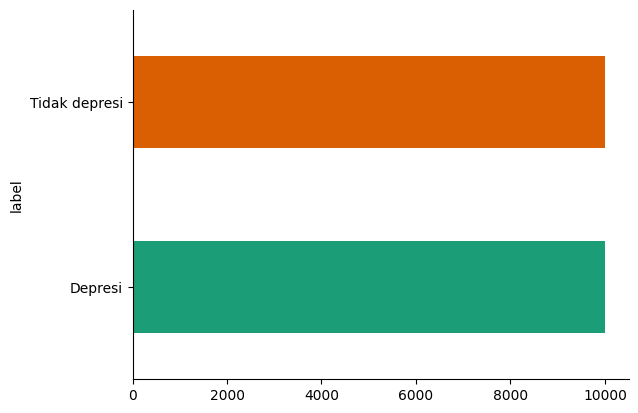

In [ ]:
#Persiapan Dataset Visualisasi Dataset
from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
feature = data['stemming_clean']
target = data['label']

x_train,x_test,y_train,y_test = train_test_split(feature,target,test_size=0.3,random_state=21)


In [ ]:
#Model Vectorizer
vec_model = TfidfVectorizer().fit(x_train)
vec_data = vec_model.transform(x_train)
vec_data = vec_model.transform(x_train)

In [ ]:
#Model Naive Bayes
cls_model_mnb = MultinomialNB().fit(vec_data,y_train)
training_mnb = cls_model_mnb.score(vec_data,y_train)
print('Akurasi Training NaiveBayes:',training_mnb)

#klasifikasi mnb
test_data = vec_model.transform(x_test)
mnb = cls_model_mnb.score(test_data,y_test)
print('Akurasi Testing NaiveBayes:',mnb)

Akurasi Training NaiveBayes: 0.9529285714285715
Akurasi Testing NaiveBayes: 0.8603333333333333


In [ ]:
#Model SVC
cls_model_svc = SVC().fit(vec_data,y_train)
training_svc = cls_model_svc.score(vec_data,y_train)
print('Akurasi Training SVC:',training_svc)

#klasifikasi svc
test_data = vec_model.transform(x_test)
svc = cls_model_svc.score(test_data,y_test)
print('Akurasi Testing SVC:',svc)

Akurasi Training SVC: 0.995
Akurasi Testing SVC: 0.864


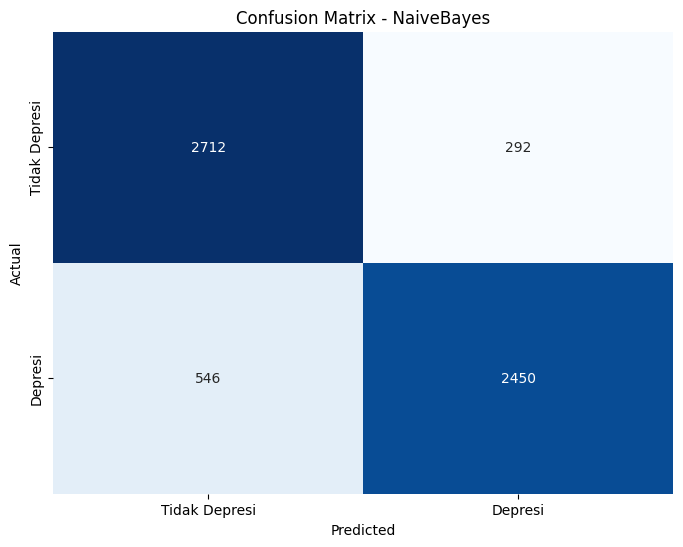

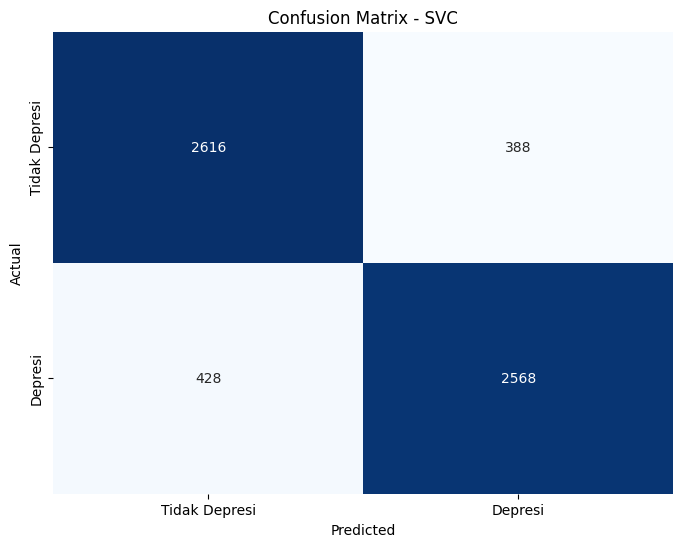

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming cls_model_mnb and cls_model_svc are your trained models
mnb_predictions = cls_model_mnb.predict(test_data)
svc_predictions = cls_model_svc.predict(test_data)

# Create confusion matrices
conf_matrix_mnb = confusion_matrix(y_test, mnb_predictions)
conf_matrix_svc = confusion_matrix(y_test, svc_predictions)

# Plot confusion matrix for NaiveBayes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mnb, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Tidak Depresi', 'Depresi'], yticklabels=['Tidak Depresi', 'Depresi'])
plt.title('Confusion Matrix - NaiveBayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot confusion matrix for SVC
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svc, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Tidak Depresi', 'Depresi'], yticklabels=['Tidak Depresi', 'Depresi'])
plt.title('Confusion Matrix - SVC')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
#Confusion Matrix
from sklearn.metrics import classification_report
print("classification Report Naive Bayes")
print(classification_report(y_test, mnb_predictions ))


classification Report Naive Bayes
               precision    recall  f1-score   support

      Depresi       0.83      0.90      0.87      3004
Tidak depresi       0.89      0.82      0.85      2996

     accuracy                           0.86      6000
    macro avg       0.86      0.86      0.86      6000
 weighted avg       0.86      0.86      0.86      6000



In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Assuming cls_model_mnb is your trained NaiveBayes model
mnb_predictions = cls_model_mnb.predict(test_data)

# Create confusion matrix
conf_matrix_mnb = confusion_matrix(y_test, mnb_predictions)

# Calculate accuracy for each class
accuracy_class_0 = conf_matrix_mnb[0, 0] / np.sum(conf_matrix_mnb[0, :])
accuracy_class_1 = conf_matrix_mnb[1, 1] / np.sum(conf_matrix_mnb[1, :])

# Print accuracies
print('Accuracy for Class "tidak depresi":', accuracy_class_0)
print('Accuracy for Class "depresi":', accuracy_class_1)

# Overall accuracy
overall_accuracy = accuracy_score(y_test, mnb_predictions)
print('Overall Accuracy:', overall_accuracy)


Accuracy for Class "tidak depresi": 0.9027962716378163
Accuracy for Class "depresi": 0.8177570093457944
Overall Accuracy: 0.8603333333333333


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Assuming cls_model_svc is your trained SVC model
svc_predictions = cls_model_svc.predict(test_data)

# Create confusion matrix
conf_matrix_svc = confusion_matrix(y_test, svc_predictions)

# Calculate accuracy for each class
accuracy_class_0 = conf_matrix_svc[0, 0] / np.sum(conf_matrix_svc[0, :])
accuracy_class_1 = conf_matrix_svc[1, 1] / np.sum(conf_matrix_svc[1, :])

# Print accuracies
print('Accuracy for Class "tidak depresi":', accuracy_class_0)
print('Accuracy for Class "depresi":', accuracy_class_1)

# Overall accuracy
overall_accuracy_svc = accuracy_score(y_test, svc_predictions)
print('Overall Accuracy (SVC):', overall_accuracy_svc)


Accuracy for Class "tidak depresi": 0.8708388814913449
Accuracy for Class "depresi": 0.8571428571428571
Overall Accuracy (SVC): 0.864


In [ ]:
print("classification Report SVC")
print(classification_report(y_test, svc_predictions))

classification Report SVC
               precision    recall  f1-score   support

      Depresi       0.86      0.87      0.87      3004
Tidak depresi       0.87      0.86      0.86      2996

     accuracy                           0.86      6000
    macro avg       0.86      0.86      0.86      6000
 weighted avg       0.86      0.86      0.86      6000



###Visualisasi Data

In [ ]:
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [ ]:
data = pd.read_excel('data_no.xlsx')
label = "Depresi"
df_depresi = data[data['label'].str.lower() == label.lower()]
df_depresi.to_excel('data_depresi.xlsx')

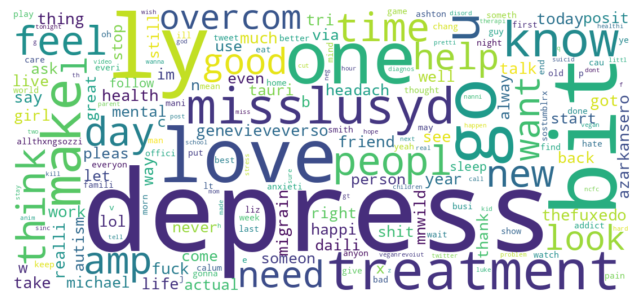

In [ ]:
# Assuming df_positif is your DataFrame containing the text column 'stemming_clean'
text = df_depresi['stemming_clean'].str.cat(sep=' ')
wordcloud = WordCloud(width=1100, height=500, random_state=3, background_color='white',
                      max_font_size=200, collocations=False).generate(text)

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
data = pd.read_excel('data_no.xlsx')
label = "Tidak depresi"
df_nodepresi = data[data['label'].str.lower() == label.lower()]
df_nodepresi.to_excel('data_nodepresi.xlsx')

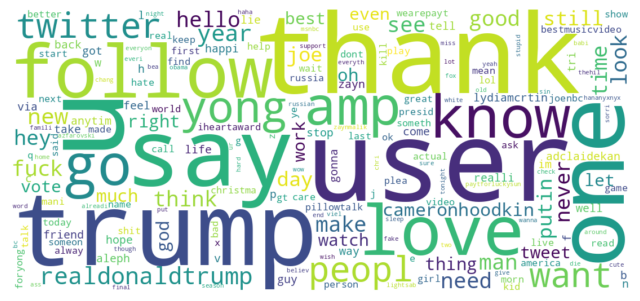

In [ ]:
# Assuming df_positif is your DataFrame containing the text column 'stemming_clean'
text = df_nodepresi['stemming_clean'].str.cat(sep=' ')
wordcloud = WordCloud(width=1100, height=500, random_state=3, background_color='white',
                      max_font_size=200, collocations=False).generate(text)

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


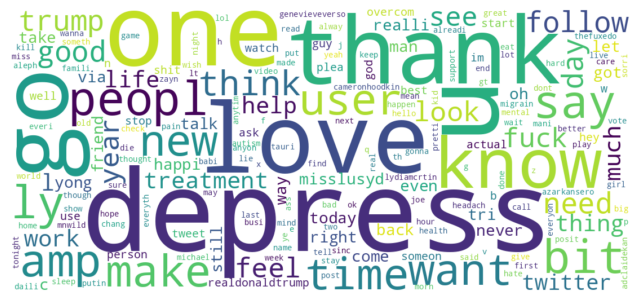

In [ ]:
#Visualisasi Wordcloud Semua
data_smua = pd.read_excel('data_no.xlsx')
text = data_smua['stemming_clean'].str.cat(sep=' ')
wordcloud = WordCloud(width=1100, height=500, random_state=3, background_color='white',
                      max_font_size=200, collocations=False).generate(text)

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
print("\n",
      "\n",text.count("depress"),
      "\n",text.count("know"),
      "\n",text.count("thank"),
      "\n",text.count("love"),
      "\n",text.count("one"),
      "\n",text.count("want"),
      "\n",text.count("feel"),
      "\n",text.count("make"),
      "\n",text.count("say"),
      "\n",text.count("think"),
      "\n",text.count("fuck"),

     )


 
 1046 
 728 
 702 
 760 
 1345 
 514 
 483 
 553 
 612 
 523 
 483


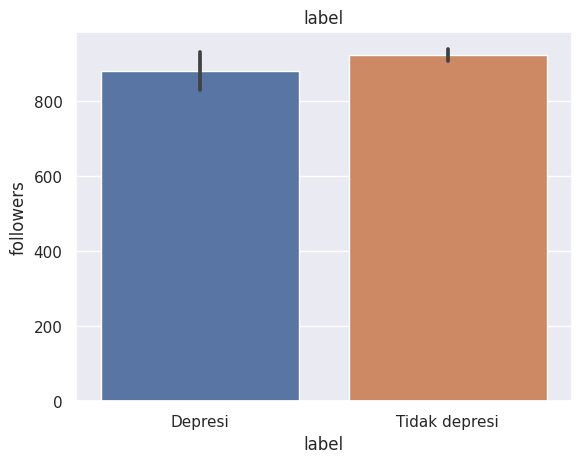

In [ ]:
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)
sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 0.6})
sns.set(rc = {'figure.figsize':(11,5)})
sns.barplot(data=data, x="label", y="followers").set(title="label");

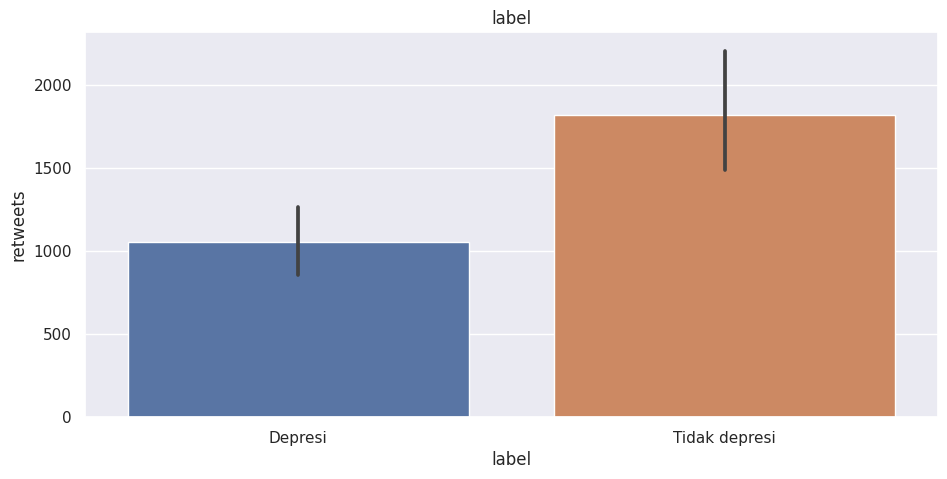

In [ ]:
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)
sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 0.6})
sns.set(rc = {'figure.figsize':(11,5)})
sns.barplot(data=data, x="label", y="retweets").set(title="label");

###Prediksi

In [ ]:
# mau memasukan data sebanyak berapa n
n = int(input("Berapa banyak data yang ingin diinputkan? "))

# Membuat list kosong
data_inputan = []

# Mengambil input dari keyboard sebanyak n kali
for i in range(n):
    data = input("Masukkan Kalimat Yang akan Diprediksi: ")
    # Menambahkan data ke dalam list
    data_inputan.append(data)

#Vektorisasi
teks_vec = vec_model.transform(data_inputan)

#Prediksi/Klasifikasi
# teks_pred = cls_model_mnb.predict(teks_vec) # Naive Bayes
teks_pred = cls_model_svc.predict(teks_vec) #SVC

#Hasil Prediksi
for i, elemen in enumerate(data_inputan):
    print(f"Kalimat yang diprediksi ke-{i}: {elemen}")
for idx,i in enumerate(teks_pred):
    print("Sentimen kalimat ke " + str(idx) + " Adalah " + i)

Berapa banyak data yang ingin diinputkan? 1
Masukkan Kalimat Yang akan Diprediksi: I feel sad
Kalimat yang diprediksi ke-0: I feel sad
Sentimen kalimat ke 0 Adalah Depresi


###Hasil & Kesimpulan
Berdasarkan hasil sentiment analysis tersebut dapat diketahui bahwa perbincangan mengenai mental health seperti 'depresi' sering dibahas di platform X/twitter. hal itu terlihat dari visualisasi wordcloud kata yang paling sering muncul adalah 'depress' dan 'one'.

